In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import math

from methods import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loads files as dataframes
data_ent_followup = create_df("f_Sections F,G,h - Ent.dta", "Analysis files/data/Followup/{0}")

data_edu_baseline = create_df("education.dta", "Analysis files/data/Baseline/{0}")

data_ent_baseline = create_df("Sections F,G,h - Ent.dta", "Analysis files/data/Baseline/{0}")

data_age_baseline = create_df("personal info.dta", "Analysis files/data/Baseline/{0}")

In [3]:
#Removes attrition from the baseline dataframes
updated_edu_baseline = remove_attrition(data_edu_baseline, data_ent_followup)
updated_ent_baseline = remove_attrition(data_ent_baseline, data_ent_followup)
updated_age_baseline = remove_attrition(data_age_baseline, data_ent_followup)

Number of households at followup:  961
Number of households at adjusted baseline:  961
Number of households at followup:  961
Number of households at adjusted baseline:  961
Number of households at followup:  961
Number of households at adjusted baseline:  961


In [4]:
#Creates big array with the desired columns of edu_baseline, ent_baseline, and ent_followup.
#Contains the columns specified below.
#Corrects NaN values to zero.
ent_edu_master = updated_ent_baseline[['treatment_x', 'rescode', 'enterprise', 'soleent']].join(data_ent_followup[['f_enterprise', 'f_soleent']])
ent_edu_master = ent_edu_master.join(updated_edu_baseline[["edulow", "eduvoc", "eduhigh"]])
ent_edu_master = ent_edu_master.join(updated_age_baseline[["age"]])
ent_edu_master = ent_edu_master.fillna(0)

In [5]:
#Find number of participants in each age bin
ent_edu_master['age'] = ent_edu_master['age'].apply(lambda x: x//10)
ent_edu_master.loc[ent_edu_master.age==1, 'age'] = 3
ent_edu_master.loc[ent_edu_master.age==2, 'age'] = 3
ent_edu_master.loc[ent_edu_master.age==5, 'age'] = 4
ent_edu_master.loc[ent_edu_master.age==6, 'age'] = 4

for i in range(10):
    print(len(ent_edu_master.loc[ent_edu_master['age'] == i, :]))
    
ageBins = ['18-39', '40-69']

for i in range(3, 4):
    ent_edu_master.loc[ent_edu_master['age']==i, 'agebin'] = ageBins[i-3]



0
0
0
465
496
0
0
0
0
0


In [6]:
#add education column that has a 1,2, or 3 (and soon a 4) to indicate level of edu (or aggregate)
ent_edu_master['education'] = ent_edu_master['edulow'] + ent_edu_master['eduvoc'] * 2 + ent_edu_master['eduhigh'] * 3

#add difference column 
ent_edu_master["difference"] = ent_edu_master["f_soleent"] - ent_edu_master["soleent"]


In [7]:
ent_edu_master

,treatment_x,rescode,enterprise,soleent,f_enterprise,f_soleent,edulow,eduvoc,eduhigh,age,agebin,education,difference
0,0.0,11101,1,1.0,1,1.0,0.0,0.0,1.0,4.0,NaN,3.0,0.0
1,0.0,11102,1,1.0,0,0.0,0.0,0.0,1.0,4.0,NaN,3.0,-1.0
2,0.0,11103,1,1.0,0,0.0,0.0,0.0,1.0,4.0,NaN,3.0,-1.0
3,0.0,11201,0,0.0,1,0.0,0.0,0.0,1.0,3.0,18-39,3.0,0.0
4,0.0,11203,1,1.0,1,0.0,1.0,0.0,0.0,3.0,18-39,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,1.0,55604,1,0.0,0,0.0,0.0,0.0,1.0,3.0,18-39,3.0,0.0
957,1.0,55605,1,1.0,0,0.0,0.0,0.0,1.0,4.0,NaN,3.0,-1.0
958,1.0,55608,1,1.0,0,0.0,0.0,0.0,1.0,3.0,18-39,3.0,-1.0
959,1.0,55703,0,0.0,0,0.0,0.0,1.0,0.0,4.0,NaN,2.0,0.0


In [8]:
#Creates new data frame with twice as many rows (first set for baseline, second for followup) 
ent_edu_graphing = ent_edu_master.copy();

ent_edu_graphing["difference"] = ent_edu_graphing["f_soleent"] - ent_edu_graphing["soleent"]

#append ent_edu_graphing to itself with an education value of 4 and an age value of 10 in order to get aggregate of all edu types and age bins
copyDF = ent_edu_graphing.copy()
copyDF["education"] = 4
copyDF["age"] = 10
ent_edu_graphing = ent_edu_graphing.append(copyDF, ignore_index=True, sort=False)

print('rescode treatment_x enterprise soleent f_enterprise f_soleent edulow eduvoc eduhigh baselineOrFollowup education')

rescode treatment_x enterprise soleent f_enterprise f_soleent edulow eduvoc eduhigh baselineOrFollowup education


In [9]:
#ent_edu_graphing

In [10]:
treatment = 2

In [11]:
#pass in the master df NOT CURRENTLY BEING USED
def ci_BP(df, educationOrAge, specificBin, treatment):
    p_hat = 0.5 
    z = 1.96 #for 95% confidence
    if (specificBin == 'all'):
        n = len(df[(df["treatment_x"] == treatment)])
    else:
        n = len(df[(df["treatment_x"] == treatment) & (df[educationOrAge] == specificBin)])       
    return z * math.pow((p_hat*(1-p_hat))/n, 0.5)
    

In [12]:
def mean(column):
    sum = column.sum()
    length = len(column)
    return sum/length

def sd(column, mean):
    sum = 0
    for i in range(len(column)):
        sum = sum + math.pow(column.iloc[i] - mean, 2)
    return math.pow(sum/len(column), 0.5)

def ci_ND(column):
    mean_ = mean(column)
    sd_ = sd(column, mean_)
    return (1.96*sd_)/math.pow(len(column), 0.5)

In [13]:
#edu with THREE different categories (edulow, eduvoc, eduhigh)
counted_edu_graphing = pd.DataFrame(columns=['soleent_diff', 'error', 'edu', 'n'])
for i in range(1, 4):
    difference_count = ent_edu_master[(ent_edu_master.education == i) & (ent_edu_master.treatment_x == treatment)].difference.sum()
    total_count = len(ent_edu_master[(ent_edu_master.education == i) & (ent_edu_master.treatment_x == treatment)])
    #change error calculation !!!!!!!!!!!
    error = ci_ND(ent_edu_master[(ent_edu_master.education == i) & (ent_edu_master.treatment_x == treatment)].difference)
    counted_edu_graphing = counted_edu_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'edu': i, 'n':total_count}, ignore_index=True)
    
error = ci_ND(ent_edu_master[(ent_edu_master.treatment_x == treatment)].difference)
difference_count = ent_edu_master[ent_edu_master.treatment_x == treatment].difference.sum()
total_count = len(ent_edu_master[ent_edu_master.treatment_x == treatment])
counted_edu_graphing = counted_edu_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'edu': 4, 'n':total_count}, ignore_index=True)  

eduBins = ['low', 'voc', 'high', 'agg']

for i in range(4):
    counted_edu_graphing.loc[counted_edu_graphing.index==i, 'edubin'] = eduBins[i]

counted_edu_graphing



,soleent_diff,error,edu,n,edubin
0,0.263158,0.173909,1.0,38.0,low
1,0.166667,0.144046,2.0,72.0,voc
2,0.049793,0.067753,3.0,241.0,high
3,0.096866,0.058754,4.0,351.0,agg


<ErrorbarContainer object of 3 artists>

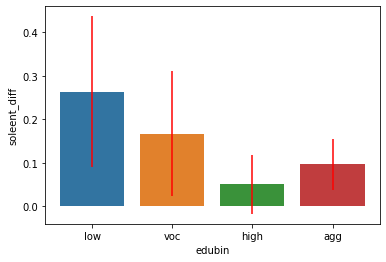

In [14]:
ax = sns.barplot(x='edubin', y="soleent_diff", data=counted_edu_graphing, ci=None)

ax.errorbar(x=counted_edu_graphing['edubin'],y=counted_edu_graphing['soleent_diff'], yerr=counted_edu_graphing['error'], fmt='none', c='r')

In [15]:
#edu with TWO different categories (edulow &eduvoc, eduhigh)
counted_edu2_graphing = pd.DataFrame(columns=['soleent_diff', 'error', 'edu', 'n'])
ent_edu_master2 = ent_edu_master.copy()
ent_edu_master2.loc[ent_edu_master2.education == 1, 'education'] = 2

for i in range(2, 4):
    difference_count = ent_edu_master2[(ent_edu_master2.education == i) & (ent_edu_master2.treatment_x == treatment)].difference.sum()
    total_count = len(ent_edu_master2[(ent_edu_master2.education == i) & (ent_edu_master2.treatment_x == treatment)])
    #change this error calculation !!!!!!
    error = ci_ND(ent_edu_master2[(ent_edu_master2.education == i) & (ent_edu_master2.treatment_x == treatment)].difference)
    counted_edu2_graphing = counted_edu2_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'edu': i, 'n':total_count}, ignore_index=True)
    
error = ci_ND(ent_edu_master2[(ent_edu_master2.treatment_x == treatment)].difference)
difference_count = ent_edu_master2[ent_edu_master2.treatment_x == treatment].difference.sum()
total_count = len(ent_edu_master2[ent_edu_master2.treatment_x == treatment])
counted_edu2_graphing = counted_edu2_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'edu': 4, 'n':total_count}, ignore_index=True)  

eduBins = ['low&voc', 'high', 'agg']

for i in range(3):
    counted_edu2_graphing.loc[counted_edu2_graphing.index==i, 'edubin'] = eduBins[i]

counted_edu2_graphing

,soleent_diff,error,edu,n,edubin
0,0.200000,0.112127,2.0,110.0,low&voc
1,0.049793,0.067753,3.0,241.0,high
2,0.096866,0.058754,4.0,351.0,agg


<ErrorbarContainer object of 3 artists>

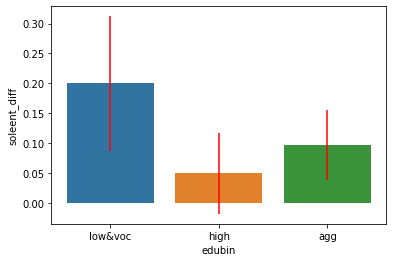

In [16]:
ax = sns.barplot(x='edubin', y="soleent_diff", data=counted_edu2_graphing, ci=None)

ax.errorbar(x=counted_edu2_graphing['edubin'],y=counted_edu2_graphing['soleent_diff'], yerr=counted_edu2_graphing['error'], fmt='none', c='r')

In [17]:
#age

counted_age_graphing = pd.DataFrame(columns=['soleent_diff', 'error', 'age', 'agebin', 'n'])
for i in range(3, 5):
    difference_count = ent_edu_master[(ent_edu_master.age == i) & (ent_edu_master.treatment_x == treatment)].difference.sum()
    total_count = len(ent_edu_master[(ent_edu_master.age == i) & (ent_edu_master.treatment_x == treatment)])
    #change error calculation
    error = ci_ND(ent_edu_master[(ent_edu_master.age == i) & (ent_edu_master.treatment_x == treatment)].difference)
    counted_age_graphing = counted_age_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'age': i, 'n':total_count}, ignore_index=True)
    
error = ci_ND(ent_edu_master[(ent_edu_master.treatment_x == treatment)].difference)
difference_count = ent_edu_master[ent_edu_master.treatment_x == treatment].difference.sum()
total_count = len(ent_edu_master[ent_edu_master.treatment_x == treatment])
counted_age_graphing = counted_age_graphing.append({'soleent_diff': difference_count/total_count, 'error': error, 'age': 10, 'n':total_count}, ignore_index=True)  

ageBins = ['18-39', '40-69', 'agg']

for i in range(3):
    counted_age_graphing.loc[counted_age_graphing.index==i, 'agebin'] = ageBins[i]

counted_age_graphing




,soleent_diff,error,age,agebin,n
0,0.142012,0.087246,3.0,18-39,169.0
1,0.054945,0.078734,4.0,40-69,182.0
2,0.096866,0.058754,10.0,agg,351.0


<ErrorbarContainer object of 3 artists>

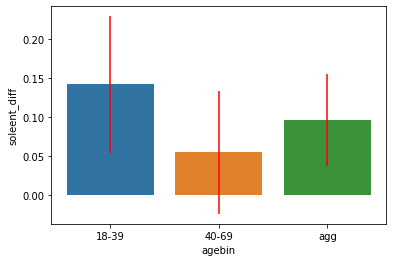

In [18]:
ax = sns.barplot(x='agebin', y="soleent_diff", data=counted_age_graphing, ci=None)

ax.errorbar(x=counted_age_graphing['agebin'],y=counted_age_graphing['soleent_diff'], yerr=counted_age_graphing['error'], fmt='none', c='r')

In [19]:
#ax = sns.barplot(x='education', y="combined_enterprise", hue="baselineOrFollowup", data=ent_edu_graphing[ent_edu_graphing['treatment_x']==treatment], ci=None)


In [20]:
#ax = sns.barplot(x='education', y="combined_enterprise", hue="baselineOrFollowup", data=ent_edu_graphing[ent_edu_graphing['treatment_x']==treatment], ci=None)


#ax.errorbar(x=ent_edu_graphing['education'],y=ent_edu_graphing['combined_enterprise'], yerr=yerrDF, fmt='none', c='r')

In [21]:
#plt.bar(x='education', height='combined_enterprise', data=ent_edu_graphing[ent_edu_graphing['treatment_x']==treatment])